# Climate diagnostics of multivariate drought and fire weather events

In [ ]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

On Pearcey, nodes have 20 cores, each with 6GB. More than 20 cores, need more than one worker. `processes` ensures the number of workers.

In [ ]:
cluster = SLURMCluster(processes=1,
                       walltime='01:30:00',
                       cores=3,
                       memory='36GB',
                       job_extra=['--qos="express"'])

In [ ]:
cluster.scale(jobs=1)

In [ ]:
client = Client(cluster)
client

In [ ]:
import xarray as xr
import numpy as np
import copy
import math
import string

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy
import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir'] = '/datasets/work/oa-dcfp/work/squ027/data/cartopy-data'
cartopy.config['data_dir'] = '/datasets/work/oa-dcfp/work/squ027/data/cartopy-data'

In [ ]:
import functions as fn

# Plotting parameters

In [ ]:
fontsize = 7
coastlines_lw = 0.5
linewidth = 1.1
patheffect_lw_add = linewidth * 1.8
    
plt_params = {'lines.linewidth': linewidth,
              
              'hatch.linewidth': 0.5,
    
              'font.size': fontsize,
              
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.03,
              'legend.handlelength' : 1.,
             
              'axes.linewidth': 0.5}

# default colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

letters = list(string.ascii_lowercase)

# Custom cmap
custom_cmap = fn.get_magma_waterlily_cmap()

# Load masks

In [ ]:
# Burned area on JRA grid
jra_ba_mask = xr.open_zarr('/scratch1/ric368/projects/fire/data/masks/jra_burned_area_mask.zarr',
                            consolidated=True).burned_cells

In [ ]:
# Jra grid cell area
jra_grid_area = xr.open_zarr('/scratch1/ric368/projects/fire/data/masks/jra_grid_area.zarr').cell_area
jra_grid_area = jra_grid_area.compute()

# Load FFDI, precip

In [ ]:
# Extreme FFDI days per year
grid_ex_dpy = xr.open_zarr('/scratch1/ric368/projects/fire/data/derived/jra_extreme_ffdi_dpy_global_1959_2020.zarr',
                             consolidated=True).ffdi_dpy

In [ ]:
# End month of fire year
grid_year_end = xr.open_zarr('/scratch1/ric368/projects/fire/data/derived/jra_ffdi_fire_year_end_month.zarr',
                             consolidated=True).month

In [ ]:
# Precipitation for fire year
grid_ypr = xr.open_zarr('/scratch1/ric368/projects/fire/data/derived/gpcc_fire_year_precip_jra_grid_global_1959_2020.zarr',
                         consolidated=True).precip

# Process diagnistics

### JRA diagnostic data
u300, v300, z200, z500, vpot200

In [ ]:
jra_isobaric_ds = xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-jra55/isobaric_month.zarr',
                               consolidated=True)
jra_isobaric_ds = jra_isobaric_ds.rename({'g0_lat_2': 'lat',
                                          'g0_lon_3': 'lon',
                                          'initial_time0_hours': 'time',
                                          'lv_ISBL1': 'level'})

In [ ]:
u300 = jra_isobaric_ds['UGRD_GDS0_ISBL'].sel(level=300).rename('u300').compute()
v300 = jra_isobaric_ds['VGRD_GDS0_ISBL'].sel(level=300).rename('v300').compute()
z200 = jra_isobaric_ds['HGT_GDS0_ISBL'].sel(level=200).rename('z200').compute()
z500 = jra_isobaric_ds['HGT_GDS0_ISBL'].sel(level=500).rename('z500').compute()
vpot200 = jra_isobaric_ds['VPOT_GDS0_ISBL'].sel(level=200).rename('vpot200').compute()

### MSLP

In [ ]:
jra_surface_ds = xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-jra55/surface_month.zarr',
                              consolidated=True)

In [ ]:
mslp = jra_surface_ds['PRMSL_GDS0_MSL'].rename({'initial_time0_hours': 'time',
                                                'g0_lat_1': 'lat',
                                                'g0_lon_2': 'lon'})
mslp = mslp.rename('mslp').compute()

#### Combine

In [ ]:
jra_ds = xr.Dataset()
jra_ds['u300'] = u300
jra_ds['v300'] = v300
jra_ds['z200'] = z200
jra_ds['z500'] = z500
jra_ds['vpot200'] = vpot200
jra_ds['mslp'] = mslp

### Climatology and anomalies

In [ ]:
jra_clim = fn.climatology_monthly(jra_ds)
jra_anom = fn.anomalise_monthly(jra_ds)

# HadISST data

In [ ]:
hadisst = xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-hadisst/ocean_month.zarr')
hadisst = hadisst['sst'].sel(time=slice('1958', '2020')).rename({'latitude': 'lat', 'longitude': 'lon'}).compute()
hadisst = hadisst.where(hadisst > -10, np.nan)

In [ ]:
sst_anom = fn.anomalise_monthly(hadisst, climatology_slice=slice('1958', '2020')).compute()

# Composites on spatially extensive compound years

### Grid cell compound events dataArray

In [ ]:
pr = grid_ypr.sel(time=slice('1959', '2020'))

ffdi_thresh = grid_ex_dpy.mean(dim='time') + grid_ex_dpy.std(dim='time')
pr_thresh = pr.mean(dim='time') - pr.std(dim='time')

# Compound (multivariate) events
cc_da = xr.where((pr < pr_thresh) &
                 (grid_ex_dpy > ffdi_thresh),
                 1,
                 0)

### Annual precip and FFDI anomalies

In [ ]:
ffdi_anoms = grid_ex_dpy - grid_ex_dpy.mean('time')

In [ ]:
pr_anoms = (pr - pr.mean('time')) / pr.std('time')

In [ ]:
# Split data into Northern Hemisphere, Tropics and Southern Hemisphere at the Tropics of Cancer and Capricorn
nh_lim = 23.44
sh_lim = -23.44

r_slices = {'N. Hem.': slice(90, nh_lim),
            'Tropics': slice(nh_lim, sh_lim),
            'S. Hem.': slice(sh_lim, -60)}

### Choose averaging period for diagnostics

- FFDI and precip are done on grid cell basis.
- We want the best 12 month period to suit the FW and precip years

In [ ]:
# Month of fire year end
ye = grid_year_end.where(jra_ba_mask == 1)
year_ends = {}
for r in r_slices.keys():
    y = ye.sel(lat=r_slices[r]).values.flatten()
    y = y[~np.isnan(y)].astype('int')
    c = np.bincount(y)
    modal_y = np.where(c == max(c))[0][0]
    year_ends[r] = modal_y
    print('Modal year end month for',r,'is',modal_y)
    print(c[1:])

In [ ]:
def get_composite_plot_data(event_da, ffdi_da, pr_da, jra_ff_da, jra_anoms_da, sst_anom_da, region_dict, year_ends_dict, mask):
    
    plot_data = {}

    for i, (r, r_s) in enumerate(zip(region_dict.keys(), region_dict.values())):

        plot_data[r] = {}

        # Total area in region
        r_tot = jra_grid_area.where(mask == 1).sel(lat=r_s).sum()
        # Proportion of area with events
        d = ((event_da.where(mask == 1).sel(lat=r_s) * jra_grid_area.sel(lat=r_s)).sum(['lat', 'lon']) / r_tot).sel(time=slice('1960', '2020'))
        # Top 10% years
        years_da = xr.where(d > d.quantile(0.9, 'time'), 1, np.nan) 
        i_years = np.where(years_da.values == 1)[0]
        years = [str(i) for i in years_da.time.dt.year.values[i_years]]
        plot_data[r]['years_str1'] = ', '.join(years[:3])
        plot_data[r]['years_str2'] = ', '.join(years[3:])
        
        # Adjust diagnostic data for correct set of months
        # Shift data forward 5 months so that you can select on year_end
        # For 3 month data, shift forward one less month so that chosen 3 months are centred on the peak FFDI month
        # Only keep data from 1960, as prior years do not always have the requisite samples on z500 for a 12m average
        year_end = year_ends_dict[r]
        
        jra_a_3 = jra_anoms_da['z500'].shift(time=4).rolling(time=3).mean().isel(time=jra_anoms_da.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
        jra_a_12_vpot = jra_anoms_da['vpot200'].shift(time=5).rolling(time=12).mean().isel(time=jra_anoms_da.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
        jra_a_12_z500 = jra_anoms_da['z500'].shift(time=5).rolling(time=12).mean().isel(time=jra_anoms_da.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
        sst_a_3 = sst_anom_da.shift(time=4).rolling(time=3).mean().isel(time=sst_anom_da.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
        sst_a_12 = sst_anom_da.shift(time=5).rolling(time=12).mean().isel(time=sst_anom_da.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))

        p_ffdi = ffdi_da.isel(time=i_years).mean('time').where(mask==1)
        plot_data[r]['ffdi'] = xr.where(p_ffdi.isnull(), -999, p_ffdi)

        p_pr = pr_da.isel(time=i_years).mean('time').where(mask==1)
        plot_data[r]['pr'] = xr.where(p_pr.isnull(), -999, p_pr)
        
        p_sst_3 = sst_a_3.isel(time=i_years).mean('time')
        plot_data[r]['sst3'] = xr.where(p_sst_3.isnull(), -999, p_sst_3)
    
        p_sst_12 = sst_a_12.isel(time=i_years).mean('time')
        plot_data[r]['sst12'] = xr.where(p_sst_12.isnull(), -999, p_sst_12)

        plot_data[r]['jra3'] = jra_a_3.isel(time=i_years).mean('time')

        plot_data[r]['jra12_vpot'] = jra_a_12_vpot.isel(time=i_years).mean('time')
        plot_data[r]['jra12_z500'] = jra_a_12_z500.isel(time=i_years).mean('time')
        
    return plot_data

In [ ]:
%%time
plt_dict_compound = get_composite_plot_data(cc_da, ffdi_anoms, pr_anoms, jra_ds, jra_anom, sst_anom, r_slices, year_ends, mask=jra_ba_mask)

da = xr.where(grid_ex_dpy > ffdi_thresh, 1, 0)
plt_dict_fw = get_composite_plot_data(da, ffdi_anoms, pr_anoms, jra_ds, jra_anom, sst_anom, r_slices, year_ends, mask=jra_ba_mask)

da = xr.where(pr < pr_thresh, 1, 0)
plt_dict_pr = get_composite_plot_data(da, ffdi_anoms, pr_anoms, jra_ds, jra_anom, sst_anom, r_slices, year_ends, mask=jra_ba_mask)

In [ ]:
levels_dict = {}
for event, d in zip(['compound', 'ffdi', 'pr'], [plt_dict_compound, plt_dict_fw, plt_dict_pr]):
    levels_dict[event] = {}
    for var in ['ffdi', 'pr', 'sst3', 'sst12', 'jra3', 'jra12_vpot', 'jra12_z500']:
        maxs = []
        for r in r_slices.keys():
            maxs.append(np.max(abs(xr.where(d[r][var] == -999, np.nan, d[r][var]))).values)
        levels_dict[event][var] = max(maxs)

In [ ]:
levels_dict['compound']

# Figure 5: composites on widespread compound event years

In [ ]:
def plot_composites(event_name, plt_dict, region_dict, levels_dict, year_ends_dict):
        
    def roundup(x, ceil):
        """Round x up to nearest ceil"""
        return int(math.ceil(x / ceil)) * ceil
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    figsize = (6.9, 5.4)
    
    # Colormap stuff
    rgb_val = 0.9
    bad_col = np.repeat(rgb_val, 3)
    
    ffdi_cmap = custom_cmap
    ffdi_cmap.set_under(bad_col)
    
    pr_cmap = copy.copy(mpl.cm.get_cmap('BrBG'))
    pr_cmap.set_under(bad_col)
    
    sst_cmap = copy.copy(mpl.cm.get_cmap('RdBu_r'))
    sst_cmap.set_under(bad_col, alpha=0)
    
    add_cbar = False

    with plt.rc_context(plt_params):
        fig, ax = plt.subplots(3, 2, figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

        for i, (r, r_s) in enumerate(zip(region_dict.keys(), region_dict.values())):
            
            # === Plot
            # Precip
            m_pr = roundup(levels_dict['pr'], .5)
            p_pr = plt_dict[r]['pr'].plot(ax=ax[i,0],
                                          transform=ccrs.PlateCarree(),
                                          vmin=-m_pr,
                                          vmax=m_pr,
                                          cmap=pr_cmap,
                                          add_colorbar=add_cbar,
                                          zorder=3,
                                          rasterized=True)
            
            # SST 12m
            m_sst = roundup(levels_dict['sst12'], .5)
            p_sst12 = plt_dict[r]['sst12'].plot(ax=ax[i,0],
                                            transform=ccrs.PlateCarree(),
                                            vmin=-m_sst,
                                            vmax=m_sst,
                                            cmap=sst_cmap,
                                            add_colorbar=add_cbar,
                                            zorder=4,
                                            rasterized=True)
            
            # VPOT
            m = roundup(levels_dict['jra12_vpot'], 1e6)
            levels = np.arange(-m, m+1, .5e6)
            levels = [i for i in levels if i != 0]
            print('VPOT levels:', levels)
            plt_dict[r]['jra12_vpot'].plot.contour(ax=ax[i,0],
                                                   transform=ccrs.PlateCarree(),
                                                   levels=levels,
                                                   colors=colors[6],
                                                   linewidths=.8,
                                                   zorder=6)
            
            # 12m Z500
            m = roundup(levels_dict['jra12_z500'], 15)
            levels = np.arange(-m, m+1, 10)
            levels = [i for i in levels if i != 0]
            print('12 month z500 levels:', levels)
            plt_dict[r]['jra12_z500'].plot.contour(ax=ax[i,0],
                                                   transform=ccrs.PlateCarree(),
                                                   levels=levels,
                                                   colors='k',
                                                   linewidths=.6,
                                                   zorder=6)
            
            # FFDI
            m_ffdi = roundup(levels_dict['ffdi'], 5)
            p_ffdi = plt_dict[r]['ffdi'].plot(ax=ax[i,1],
                                              transform=ccrs.PlateCarree(),
                                              vmin=-m_ffdi,
                                              vmax=m_ffdi,
                                              cmap=ffdi_cmap,
                                              add_colorbar=add_cbar,
                                              zorder=1,
                                              rasterized=True)
            
            # 3m Z500
            m = roundup(levels_dict['jra3'], 65)
            levels = np.arange(-m, m+1, 10)
            levels = [i for i in levels if i != 0]
            print('3 month z500 levels:', levels)
            plt_dict[r]['jra3'].plot.contour(ax=ax[i,1],
                                             transform=ccrs.PlateCarree(),
                                             levels=levels,
                                             colors='k',
                                             linewidths=.6,
                                             zorder=6)
            
            # === Titles and labels
            ax[i,0].text(-0.08,
                         0.5,
                         r+'\nModal peak FFDI: '+months[(year_ends_dict[r] - 6) % 12]+'\n'+plt_dict[r]['years_str1']+'\n'+plt_dict[r]['years_str2'],
                         transform=ax[i,0].transAxes,
                         rotation=90,
                         ha='center',
                         va='center',
                         fontsize=plt_params['font.size']-1)
              
        # === Axis stuff
        labels = [r'$\bf{'+letter+'}$' for letter in letters]
        props = dict(facecolor='w', edgecolor='w', pad=0.8)
        for a, label in zip(ax.flatten(), labels):
            a.coastlines(color='black', lw=coastlines_lw, zorder=5)
            a.set_global()
            a.add_feature(cartopy.feature.LAND, color=bad_col, zorder=0)
            a.add_feature(cartopy.feature.OCEAN, color='w', zorder=2)
            for k, spine in a.spines.items():  #ax.spines is a dictionary
                spine.set_zorder(10)
            a.set_title('')
            a.text(0.01, 0.98, label, bbox=props,
                    ha='left', va='top', transform=a.transAxes, zorder=12)

        # === Colorbars
        cb_ax = fig.add_axes([0.14, 0.11, 0.35, 0.01])
        cb = fig.colorbar(p_pr, cax=cb_ax, orientation='horizontal', extend='neither', ticks=np.arange(-m_pr, m_pr+0.001, 0.5))
        cb.ax.set_xlabel(r'$P_a / \sigma_{P_a}$ anomaly [-]')
    
        cb_ax = fig.add_axes([0.14, 0.03, 0.35, 0.01])
        cb = fig.colorbar(p_sst12, cax=cb_ax, orientation='horizontal', extend='neither', ticks=np.arange(-m_sst, m_sst+0.001, 0.5))
        cb.ax.set_xlabel(r'$\mathrm{SST}$ anomaly [K]')
        
        cb_ax = fig.add_axes([0.535, 0.11, 0.35, 0.01])
        cb = fig.colorbar(p_ffdi, cax=cb_ax, orientation='horizontal', extend='neither', ticks=np.arange(-m_ffdi, m_ffdi+0.001, 10))
        cb.ax.set_xlabel(r'$\mathrm{FWD}_f$ anomaly [days]', )
    
    plt.subplots_adjust(hspace=0.02, wspace=0.02)
    
    plt.savefig('./figures/extreme_years_composite_'+event_name+'.pdf', bbox_inches='tight', format='pdf', dpi=400)

In [ ]:
%%time
plot_composites('compound_ba_mask', plt_dict_compound, r_slices, levels_dict['compound'], year_ends)

# Figures S5, S6, S7: composites for each year
- Note some code repetition

In [48]:
def plot_yearly_composites(zone, mask, cbar_extends):
    
    rgb_val = 0.9
    bad_col = np.repeat(rgb_val, 3)
    ffdi_cmap = custom_cmap
    ffdi_cmap.set_under(bad_col)
    pr_cmap = copy.copy(mpl.cm.get_cmap('BrBG'))
    pr_cmap.set_under(bad_col)
    sst_cmap = copy.copy(mpl.cm.get_cmap('RdBu_r'))
    sst_cmap.set_under(bad_col, alpha=0)
    add_cbar=False
    
    ### =================== Get years
    r_s = r_slices[zone]
    # Total area in region
    r_tot = jra_grid_area.where(mask == 1).sel(lat=r_s).sum()
    # Proportion of area with events
    d = ((cc_da.where(mask == 1).sel(lat=r_s) * jra_grid_area.sel(lat=r_s)).sum(['lat', 'lon']) / r_tot).sel(time=slice('1960', '2020'))
    # Top 10% years
    years_da = xr.where(d > d.quantile(0.9, 'time'), 1, np.nan) 
    i_years = np.where(years_da.values == 1)[0]
    years = [str(i) for i in years_da.time.dt.year.values[i_years]]
    
    year_end = year_ends[zone]
    
    ### ================== Plot
    with plt.rc_context(plt_params):
        fig, ax = plt.subplots(len(years), 3, figsize=(6.9,7.5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

        for i,year in enumerate(years):

            # Precip
            m_pr = 3
            # Dummy plot to ensure cbar doesn't include NaNs
            p_pr = pr_anoms.sel(time=year).plot(ax=ax[i,0],
                                          transform=ccrs.PlateCarree(),
                                          vmin=-m_pr,
                                          vmax=m_pr,
                                          cmap='BrBG',
                                          add_colorbar=add_cbar,
                                          zorder=0,
                          rasterized=True)
            pr = pr_anoms.sel(time=year).where(mask==1).squeeze()
    #         print(pr.min().values, pr.max().values)
            pr.plot(ax=ax[i,0],
                                          transform=ccrs.PlateCarree(),
                                          vmin=-m_pr,
                                          vmax=m_pr,
                                          cmap=pr_cmap,
                                          add_colorbar=add_cbar,
                                          zorder=3,
                          rasterized=True)

            # SST 12m
            m_sst = 3
            sst_a_12 = sst_anom.shift(time=5).rolling(time=12).mean().isel(time=sst_anom.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
            sst_a_12 = sst_a_12.sel(time=year).squeeze()
    #         print(sst_a_12.min().values, sst_a_12.max().values)
            p_sst12 = sst_a_12.plot(ax=ax[i,0],
                                            transform=ccrs.PlateCarree(),
                                            vmin=-m_sst,
                                            vmax=m_sst,
                                            cmap=sst_cmap,
                                            add_colorbar=add_cbar,
                                            zorder=4,
                          rasterized=True)

            # VPOT
            jra_a_12_vpot = jra_anom['vpot200'].shift(time=5).rolling(time=12).mean().isel(time=jra_anom.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
            jra_a_12_vpot = jra_a_12_vpot.sel(time=year).squeeze()
            levels = np.arange(-6e6, 6.1e6, 1e6)
            levels = [i for i in levels if i != 0]
            jra_a_12_vpot.plot.contour(ax=ax[i,0],
                                                   transform=ccrs.PlateCarree(),
                                                   levels=levels,
                                                   colors=colors[6],
                                                   linewidths=.8,
                                                   zorder=6)

            # 12m Z500
            jra_a_12_z500 = jra_anom['z500'].shift(time=5).rolling(time=12).mean().isel(time=jra_anom.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
            jra_a_12_z500 = jra_a_12_z500.sel(time=year).squeeze()
            levels = np.arange(-120, 121, 15)
            levels = [i for i in levels if i != 0]
            jra_a_12_z500.plot.contour(ax=ax[i,0],
                                                   transform=ccrs.PlateCarree(),
                                                   levels=levels,
                                                   colors='k',
                                                   linewidths=.6,
                                                   zorder=6)

            # FFDI
            ffdi = ffdi_anoms.sel(time=year).where(mask==1).squeeze()
            m_ffdi = 50 #roundup(levels_dict['ffdi'], 1)
    #         print(ffdi.min().values, ffdi.max().values)
            p_ffdi = ffdi.plot(ax=ax[i,1],
                                              transform=ccrs.PlateCarree(),
                                              vmin=-m_ffdi,
                                              vmax=m_ffdi,
                                              cmap=ffdi_cmap,
                                              add_colorbar=add_cbar,
                                              zorder=1,
                          rasterized=True)

            # 3m Z500
            jra_a_3 = jra_anom['z500'].shift(time=4).rolling(time=3).mean().isel(time=jra_anom.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
            jra_a_3 = jra_a_3.sel(time=year).squeeze()
            levels = np.arange(-120, 121, 20)
            levels = [i for i in levels if i != 0]
            jra_a_3.plot.contour(ax=ax[i,1],
                                             transform=ccrs.PlateCarree(),
                                             levels=levels,
                                             colors='k',
                                             linewidths=.6,
                                             zorder=6)

            # 3m u300
            jra_a_3_u300 = jra_ds['u300'].shift(time=4).rolling(time=3).mean().isel(time=jra_ds.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
            jra_a_3_u300 = jra_a_3_u300.sel(time=year).squeeze()
            levels = np.arange(-100,101,10)
            levels = [i for i in levels if i != 0]
            jra_a_3_u300.plot.contour(ax=ax[i,2], transform=ccrs.PlateCarree(),
                                             levels=levels,
                                             colors='k',
                                             linewidths=.6,
                                             zorder=6)

            # 3m v300
    #         jra_a_3_v300 = jra_anom['v300'].shift(time=4).rolling(time=3).mean().isel(time=jra_anom.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
            jra_a_3_v300 = jra_ds['v300'].shift(time=4).rolling(time=3).mean().isel(time=jra_ds.groupby('time.month').groups[year_end]).sel(time=slice('1960', '2020'))
            jra_a_3_v300 = jra_a_3_v300.sel(time=year).squeeze()
    #         print(jra_a_3_v300.min().values, jra_a_3_v300.max().values)
    #         print()
            m_v300 = 15
            p_v300 = jra_a_3_v300.plot(ax=ax[i,2], transform=ccrs.PlateCarree(),
                                              vmin=-m_v300,
                                              vmax=m_v300,
                                              cmap='RdBu_r',
                                              add_colorbar=add_cbar,
                                              zorder=3,
                          rasterized=True)

            ax[i,0].text(-0.05, 0.5, year, ha='left', va='center', rotation=90, transform=ax[i,0].transAxes, fontsize=plt_params['font.size']-2)


        for a in ax.flatten():
            a.coastlines(color='black', lw=coastlines_lw, zorder=5)
            a.set_global()
            a.add_feature(cartopy.feature.LAND, color=bad_col, zorder=0)
            a.add_feature(cartopy.feature.OCEAN, color='w', zorder=2)
            for k, spine in a.spines.items():  #ax.spines is a dictionary
                spine.set_zorder(10)
            a.set_title('')

        # === Colorbars
        cb_ax = fig.add_axes([0.14, 0.11, 0.22, 0.01])
        cb = fig.colorbar(p_pr, cax=cb_ax, orientation='horizontal', extend=cbar_extends[0], ticks=np.arange(-m_pr, m_pr+0.001, 1))
        cb.ax.set_xlabel(r'$P_a / \sigma_{P_a}$ anomaly [-]', fontsize=plt_params['font.size'])
#         cb.ax.tick_params(labelsize=7) 

        cb_ax = fig.add_axes([0.14, 0.04, 0.22, 0.01])
        cb = fig.colorbar(p_sst12, cax=cb_ax, orientation='horizontal', extend=cbar_extends[1], ticks=np.arange(-m_sst, m_sst+0.001, 1))
        cb.ax.set_xlabel(r'$\mathrm{SST}$ anomaly [K]', fontsize=plt_params['font.size'])
#         cb.ax.tick_params(labelsize=7)

        cb_ax = fig.add_axes([0.4, 0.11, 0.22, 0.01])
        cb = fig.colorbar(p_ffdi, cax=cb_ax, orientation='horizontal', extend=cbar_extends[2], ticks=np.arange(-m_ffdi, m_ffdi+0.001, 20))
        cb.ax.set_xlabel(r'$\mathrm{FWD}_f$ anomaly [days]', fontsize=plt_params['font.size'])
#         cb.ax.tick_params(labelsize=7)

        cb_ax = fig.add_axes([0.66, 0.11, 0.22, 0.01])
        cb = fig.colorbar(p_v300, cax=cb_ax, orientation='horizontal', extend=cbar_extends[3], ticks=np.arange(-m_v300, m_v300+0.001, 6))
        cb.ax.set_xlabel(r"$v_{300}$ [m s$^{-1}$]", fontsize=plt_params['font.size'])
#         cb.ax.tick_params(labelsize=7)

        plt.subplots_adjust(hspace=0.02, wspace=0.02)

        plt.savefig('./figures/extreme_years_individual_'+zone.replace(' ', '')+'.pdf', bbox_inches='tight', format='pdf', dpi=400)

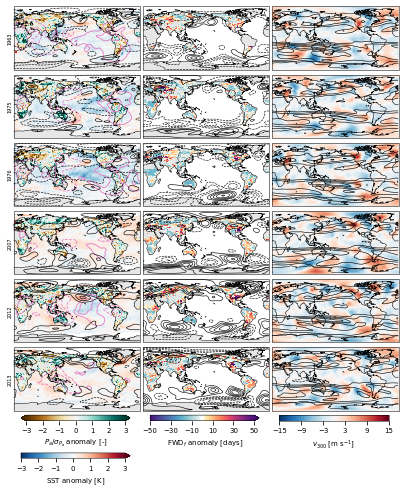

In [49]:
plot_yearly_composites('N. Hem.', jra_ba_mask, cbar_extends=['both', 'max', 'max', 'neither'])

In [ ]:
plot_yearly_composites('Tropics', jra_ba_mask, cbar_extends=['both', 'max', 'max', 'neither'])

In [ ]:
plot_yearly_composites('S. Hem.', jra_ba_mask, cbar_extends=['both', 'max', 'max', 'both'])

# Close cluster

In [ ]:
client.close()
cluster.close()